<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/Muffin_vs_Chihuahua_image_classification_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from sklearn.preprocessing import LabelEncoder
import timeit
import cv2 as cv
import argparse

#Neural Network packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision import models
from torch.autograd import Variable

In [ ]:
import glob
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px



import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# Device selection(GPU or CPU)
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#Check the size of input images
im=Image.open('/content/train/chihuahua/img_0_0.jpg')
width, height= im.size
print(width,height)

612 612


In [ ]:
# set tranformations for images
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0,0,0], 
                                                    [1,1,1])])

In [ ]:
# Custom Dataset Class
class INTELDataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
   
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.convert('RGB')
        #image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label


    def __len__(self):
      return len(self.img_data)
           


In [ ]:
base_path_train='/content'

In [ ]:
images_train=[]
labels_train=[]


for file in os.listdir(os.path.join(base_path_train,'train')):
  if file=='chihuahua':
    for img in os.listdir(os.path.join(base_path_train,'train', file)):
      images_train.append(img)
      labels_train.append('chihuahua')
  if file=='muffin':
    for img in os.listdir(os.path.join(base_path_train,'train', file)):
      images_train.append(img)
      labels_train.append('muffin')      
   

data_train= {'Images': images_train, 'labels':labels_train}     
data_train=pd.DataFrame(data_train)
print(data_train.head(10))

           Images  labels
0   img_0_393.jpg  muffin
1   img_2_602.jpg  muffin
2  img_3_1038.jpg  muffin
3   img_1_915.jpg  muffin
4   img_0_271.jpg  muffin
5   img_4_928.jpg  muffin
6   img_1_566.jpg  muffin
7   img_1_489.jpg  muffin
8   img_2_174.jpg  muffin
9   img_3_921.jpg  muffin


In [ ]:
data_train.labels.value_counts()

chihuahua    2559
muffin       2174
Name: labels, dtype: int64

In [ ]:
# Encoding the string labels to digits
encoder= LabelEncoder()
data_train['encoded_labels']= encoder.fit_transform(data_train['labels'])
data_train.head(10)
data_train.encoded_labels.value_counts()

0    2559
1    2174
Name: encoded_labels, dtype: int64

In [ ]:
train_batch_size=32
random_seed=50

In [ ]:
# Create train sampler
train_indices = list(range(len(data_train)))

train_sampler = SubsetRandomSampler(train_indices)

In [ ]:
#training image path
path_train=os.path.join(base_path_train,'train')
print(path_train)

/content/train


In [ ]:
dataset_train = INTELDataset(data_train, path_train, transform)



train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=train_batch_size, 
                                           sampler=train_sampler)

Creating Test data labels

In [ ]:
#Check the size of a test images
im=Image.open('/content/test/chihuahua/img_0_1071.jpg')
width, height= im.size
print(width,height)

300 200


In [ ]:
base_path_test= '/content'

In [ ]:
images_test=[]
labels_test=[]


for file in os.listdir(os.path.join(base_path_test,'test')):
  if file=='chihuahua':
    for img in os.listdir(os.path.join(base_path_test,'test', file)):
      images_test.append(img)
      labels_test.append('chihuahua')
  if file=='muffin':
    for img in os.listdir(os.path.join(base_path_test,'test', file)):
      images_test.append(img)
      labels_test.append('muffin')      
     

data_test= {'Images': images_test, 'labels':labels_test}     
data_test=pd.DataFrame(data_test)
print(data_test.head(10))


          Images  labels
0  img_1_738.jpg  muffin
1  img_1_247.jpg  muffin
2   img_3_28.jpg  muffin
3  img_0_871.jpg  muffin
4   img_2_22.jpg  muffin
5  img_2_427.jpg  muffin
6  img_2_535.jpg  muffin
7   img_2_29.jpg  muffin
8  img_4_748.jpg  muffin
9  img_1_645.jpg  muffin


In [ ]:
# Encoding the string labels to digits
encoder= LabelEncoder()
data_test['encoded_labels']= encoder.fit_transform(data_test['labels'])
data_test.head(10)
data_test.encoded_labels.value_counts()

0    640
1    544
Name: encoded_labels, dtype: int64

In [ ]:
path_test=os.path.join(base_path_test,'test')

Creating Test Sampler

In [ ]:

test_indices = list(range(len(data_test)))

test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
test_batch_size=20

In [ ]:
dataset_test = INTELDataset(data_test, path_test,transform)



test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch_size, 
                                           sampler=test_sampler)

Function for Training

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.cuda()
    model.train()
    train_losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):
       
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use cross entropy in pytorch)
        loss = criterion(output, target)
        #appending train loss list
        train_losses.append(loss.item())
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
     
        if batch_idx % 32 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return train_losses

Function for Testing

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            #print(output)
         
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #print(output)
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



Training and Testing using pretrained Resnet50

In [ ]:
#from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
from torchvision.models import resnet50

# With weights:
model = resnet50(pretrained=True)

# Without weights:
model = resnet50(pretrained=False)


for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss().cuda()
#Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 11):

  train(model, device, train_loader, criterion, optimizer, epoch)
  test(model, device, test_loader, criterion)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )  



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 1 [0/4733 (0%)]	Loss: 1.758729
Train Epoch: 1 [1024/4733 (22%)]	Loss: 0.639026
Train Epoch: 1 [2048/4733 (43%)]	Loss: 0.736810
Train Epoch: 1 [3072/4733 (65%)]	Loss: 1.186335
Train Epoch: 1 [4096/4733 (86%)]	Loss: 0.525152

Test set: Average loss: 0.0375, Accuracy: 740/1184 (62%)

Train Epoch: 2 [0/4733 (0%)]	Loss: 1.064155
Train Epoch: 2 [1024/4733 (22%)]	Loss: 2.165292
Train Epoch: 2 [2048/4733 (43%)]	Loss: 0.535488
Train Epoch: 2 [3072/4733 (65%)]	Loss: 0.701624
Train Epoch: 2 [4096/4733 (86%)]	Loss: 2.020882

Test set: Average loss: 0.0334, Accuracy: 849/1184 (72%)

Train Epoch: 3 [0/4733 (0%)]	Loss: 0.508373
Train Epoch: 3 [1024/4733 (22%)]	Loss: 0.635161
Train Epoch: 3 [2048/4733 (43%)]	Loss: 0.886227
Train Epoch: 3 [3072/4733 (65%)]	Loss: 1.297276
Train Epoch: 3 [4096/4733 (86%)]	Loss: 0.780721

Test set: Average loss: 0.0462, Accuracy: 789/1184 (67%)

Train Epoch: 4 [0/4733 (0%)]	Loss: 0.904711
Train Epoch: 4 [1024/4733 (22%)]	Loss: 0.426906
Train Epoch: 4 [2048/47

Validate the Model

In [ ]:
valid_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [ ]:
def predict_image(image):
    image_tensor = valid_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    vector={0:'chihuahua', 1:'muffin'}
    obj=vector[index]
    
        
    return obj

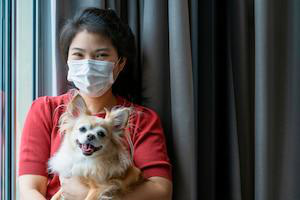

In [ ]:
im = Image.open('/content/test/chihuahua/img_0_1071.jpg')
im

In [ ]:
predict_image(im)

'chihuahua'

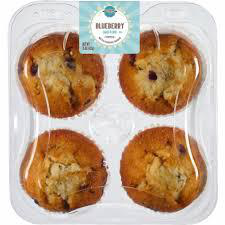

In [ ]:
im2=Image.open('/content/test/muffin/img_0_1051.jpg')
im2

In [ ]:
predict_image(im2)

'muffin'